# Normalization comparisson
In this notebook, I compare the different methods of normalization.
As a simple metric, I use the enrichment score at 99%.
This analysis is done on the efficientnetB0 pretrained output: `level3.csv`


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pycytominer import aggregate, annotate, normalize, feature_select, cyto_utils
from cytominer_eval import evaluate
from cytominer_eval.transform import metric_melt
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('level3.csv')

In [3]:
# MOA map for labels
meta_map = pd.read_csv('repurposing_info_external_moa_map_resolved.tsv', sep='\t')
meta_map = meta_map[['broad_sample', 'moa']]
df = pd.merge(df, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])

In [4]:
p = 0.99

In [5]:
def hist(df, features):
    melt = metric_melt(df.sample(200),
            features=features,
            metadata_features=meta_features)
    #bins = np.arange(-0.005, 0.005, 0.001)
    plt.style.use({'figure.facecolor':'white'})
    plt.hist(melt.similarity_metric)
def feats(df):
    features_ = []
    for col in df.columns.tolist():
        if col.startswith('efficientnet_'):
            features_.append(col)
    return features_

In [6]:
features = feats(df)
meta_features = []
for col in df.columns.tolist():
    if col.startswith('Metadata_'):
        meta_features.append(col)

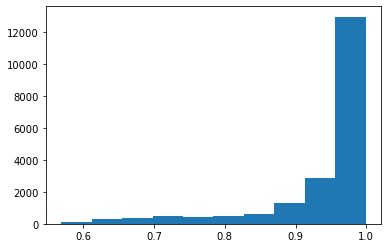

In [7]:
# plot the similarity of the wells. Expected output from a pretrained net.
hist(df,features)

Explained variation per principal component: [0.55793103 0.13111339 0.06018347]


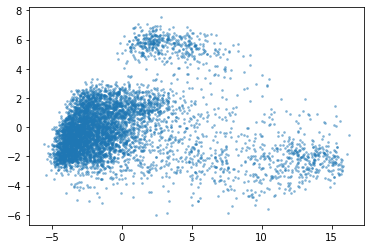

In [8]:
def pca_plot(df):
    pca = PCA(n_components=3)
    pca_result = pca.fit_transform(df[features].values)
    df['pca-one'] = pca_result[:,0]
    df['pca-two'] = pca_result[:,1]
    df['pca-three'] = pca_result[:,2]
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    plt.style.use({'figure.facecolor':'white'})
    plt.scatter(df['pca-one'], df['pca-two'], s = 3, alpha= 0.4)
    plt.show()
pca_plot(df)

## Without normalization

In [9]:
con = aggregate(
    df,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])

In [10]:
res = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "moa"],
        replicate_groups=["moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.997047,2.033252,1.750242e-12


## robustize

There doesn't seem to be a large difference between DMSO and all normalization.

In [11]:
rob_DMSO = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_DMSO,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])
res_rob_DMSO = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "moa"],
        replicate_groups=["moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_DMSO

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.861789,3.637524,9.708554e-54


In [12]:
rob_all = normalize(
    profiles=df,
    features=features,
    samples="all",
    method='robustize',
    output_file='none'
)
con = aggregate(
    rob_all,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])
res_rob_all = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "moa"],
        replicate_groups=["moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_rob_all

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.849255,3.458971,3.194248e-48


## standardize

In [13]:
stand_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='standardize',
    output_file='none'
)
con = aggregate(
    stand_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])
res_stand_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "moa"],
        replicate_groups=["moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_stand_dmso

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.855786,3.853026,1.218774e-60


## Mad robustize

In [14]:
mad_dmso = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='mad_robustize',
    output_file='none'
)
con = aggregate(
    mad_dmso,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])
res_mad_dmso = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "moa"],
        replicate_groups=["moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_mad_dmso

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.864618,3.637524,9.708554e-54


## spherize

In [15]:
sphere = normalize(
    profiles=df,
    features=features,
    samples="Metadata_broad_sample == 'DMSO'",
    method='spherize',
    output_file='none'
)
con = aggregate(
    sphere,
    strata=["Metadata_broad_sample"],
    features=features
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])
res_sphere = evaluate(
        profiles=con,
        features=features,
        meta_features=['Metadata_broad_sample', "moa"],
        replicate_groups=["moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_sphere

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.4071,7.392703,1.788596e-198


## Plot PCA
Robustize

Explained variation per principal component: [0.53431784 0.07851345 0.06567606]
Explained variation per principal component: [0.47759745 0.08688772 0.077599  ]
Explained variation per principal component: [0.5167319  0.08191322 0.06630094]
Explained variation per principal component: [0.54302208 0.07705554 0.06390366]


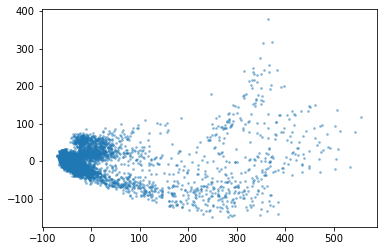

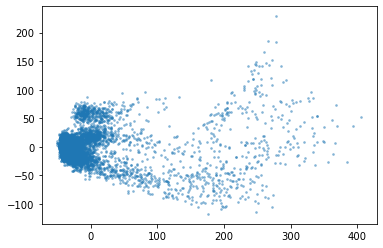

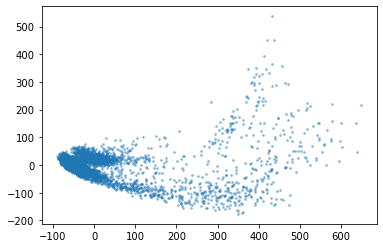

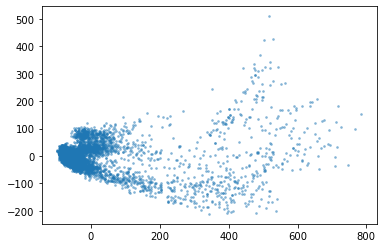

In [16]:
pca_plot(rob_DMSO)
pca_plot(rob_all)
pca_plot(stand_dmso)
pca_plot(mad_dmso)

Explained variation per principal component: [0.30767471 0.13314226 0.07910393]
Explained variation per principal component: [0.30767471 0.13314226 0.07910393]


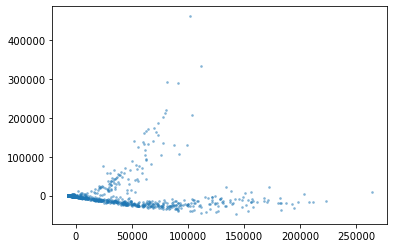

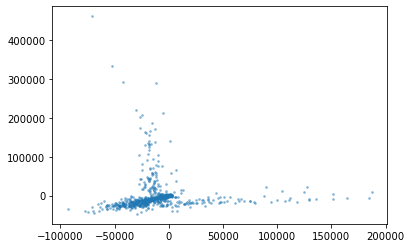

In [17]:
pca_plot(sphere)
pca = PCA(n_components=3)
pca_result = pca.fit_transform(sphere[features].values)
sphere['pca-one'] = pca_result[:,0]
sphere['pca-two'] = pca_result[:,1]
sphere['pca-three'] = pca_result[:,2]
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-three'], sphere['pca-two'], s = 3, alpha= 0.4)
plt.show()

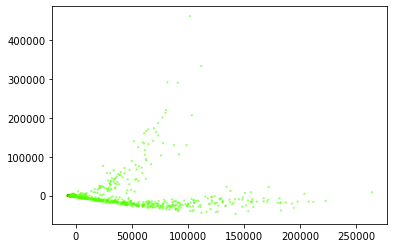

In [27]:
def is_dmso(sample):
    if sample == 'DMSO':
        return 0
    else:
        return 1
sphere['color'] = sphere.Metadata_broad_sample.apply(is_dmso)
plt.style.use({'figure.facecolor':'white'})
plt.scatter(sphere['pca-one'], sphere['pca-two'], c = sphere['color'], marker= 'o', s = 2, alpha= 0.4, cmap = 'prism')
plt.show()

## Feature selection

In [18]:
feature_select_ops = [
    "variance_threshold",
]
select_var = feature_select(
    profiles=sphere,
    features=features,
    operation=feature_select_ops,
    freq_cut=0.01,
    unique_cut=0.1,
)
print(select_var.shape)

(6098, 6409)


Variance threshold with the standard cutoffs has no effect

In [19]:
feature_select_ops = [
    "drop_outliers",
]
select_other = feature_select(
    profiles=sphere,
    features=features,
    operation=feature_select_ops,
    outlier_cutoff=10000,
)

In [20]:
features_ = feats(select_other)
con = aggregate(
    select_other,
    strata=["Metadata_broad_sample"],
    features=features_
)
con = pd.merge(con, meta_map, how='left', left_on=['Metadata_broad_sample'], right_on=['broad_sample'])
res_select_other = evaluate(
        profiles=con,
        features=features_,
        meta_features=['Metadata_broad_sample', "moa"],
        replicate_groups=["moa"],
        operation="enrichment",
        similarity_metric="pearson",
        enrichment_percentile=p
    )
res_select_other

,enrichment_percentile,threshold,ods_ratio,p-value
0,0.99,0.39716,7.553705,1.817527e-205


In [21]:
# droping a 1000 features that have very high values helps a little bit
select_other.shape

(6098, 5050)